In [1]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('order_dict.json') as f:
    data = json.load(f)
with open('capstone_jd_msom_data-minus-click-data/warehouse_capacity.json') as f2:
    warehouse_capacity = json.load(f2)

In [3]:
capacity = {int(k):v[1] for k, v in warehouse_capacity.items()}

In [4]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [5]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [6]:
def r2_loss(outputs, targets):
    target_mean = torch.mean(targets)
    ss_tot = torch.sum((targets - target_mean) ** 2)
    ss_res = torch.sum((targets - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def r2_loss_2(outputs, targets):
    ss_tot = 0.0
    ss_res = 0.0
    target_mean = torch.mean(targets)
    for i in range(0,len(outputs)):
        ss_tot += (targets[i] - target_mean) ** 2
        ss_res += (targets[i] - outputs[i]) ** 2
    r2 = 1 - ss_res / ss_tot
    return r2

# TODO: need to work with tensor objects.
def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = capacity_i / 31 # capacity_i is defined outside of this function
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost

def SPO_MSE_Loss(d_pred, d_actual):
    spo_loss = SPOLoss(d_pred, d_actual)
    mse_loss = 0.0
    for i in range(0, len(d_pred)):
        mse_loss += (d_pred[i] - d_actual[i]) ** 2
    mse_loss = mse_loss / len(d_pred)
    # mse_loss = sum((d_pred - d_actual) ** 2) / len(d_pred)    # don't use this, because d_pred can is 1*N dimention but d_actual can be N*1 dimension
    return spo_loss + 0.1 * mse_loss
 
# print(torch.Tensor.float(1.0))
outputs = torch.randn(5)
targets = torch.randn(5)
# print(outputs.size())
# for i in range(0,len(outputs)):
#   print(2)
print(r2_loss(outputs,targets))
print(r2_loss_2(outputs,targets))
#print(SPOLoss(outputs,targets))
# print(torch.randn(5))
# print(SPOLoss(1, 2))

tensor(-0.8222)
tensor(-0.8222)


In [7]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [8]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO" or "SPO_MSE", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    elif loss_type == 'SPO_MSE': # change loss function and switch to adam optimizer
        
        criterion = SPO_MSE_Loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # break loop if percent changae in loss is less than 0.1%
        if (len(loss_list) > 300) and (abs((loss.data - loss_list[-1])/loss_list[-1]) <0.0001):
            loss_list.append(loss.data)
            break
            
        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(len(loss_list)),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt.show()
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    SPO_MSE = SPO_MSE_Loss(y_pred, y_true)
    SPO_MSE_mean = SPO_MSE / len(y_pred)
    #print("Train MSE =", MSE)
    #print('Train R^2 =', R2) 
    #print('Train SPO Loss =', SPO)
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO_MSE_Weighted_Loss':SPO_MSE, 'SPO_MSE_Weighted_Loss Ave': SPO_MSE_mean, 'SPO Loss Ave': SPO_mean})

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [9]:
import timeit
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    
    # return the best penalty coefficient that minimize average validation error
    start = timeit.default_timer()
    
    aveloss = dict()
    kfold = KFold(n_splits = 5)
    
    if loss_type == 'MSE':
        learningRate = 0.02
        epochs = 301
        grid = 10**-np.linspace(0,1,11) if regularize == 'l2' else 10**-np.linspace(0,5,11)
        
    elif loss_type == 'SPO':
        learningRate = 0.05
        epochs = 301
        grid = 10**-np.linspace(-1,5,20)
        

    if regularize == 'l2':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
            #print(i)
            
    elif regularize == 'l1':
        
        for i in grid:
            loss = 0
            
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                
                loss_i = generate_scores(y_test_fold, pred_y_validate)['MSE'][0] if loss_type == 'MSE' else  generate_scores(y_test_fold, pred_y_validate)['SPO Loss'][0]
                loss += loss_i
                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(aveloss.keys(), aveloss.values())
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    print('The best penalty coefficient is '+ str(best))
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    return best

In [10]:
i = 6
x_train, y_train, x_test, y_test = preprocessing(order_dict[i])
capacity_i = capacity[i]
#capacity_i = 1000

In [11]:
#cross_validate(x_train, y_train, 'MSE', 'l2')

In [12]:
#cross_validate(x_train, y_train, 'MSE', 'l1')

In [13]:
#cross_validate(x_train, y_train, 'SPO', 'l2')

In [14]:
#cross_validate(x_train, y_train, 'SPO', 'l1')

## MSE loss models

### MSE loss model training

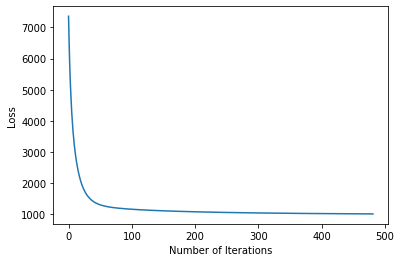

model trained using MSE loss
y-intercept  54.04863357543945
Coefficients  [[-2.1700053e+00 -2.9556947e+00 -1.9148163e+00 -3.5650487e+00
  -1.1081633e+01  7.2214327e+00  1.2235145e+01 -7.8098709e-04
   1.1071304e+01 -3.3611782e+00  5.3928328e+00  1.1416260e+01
   3.4572811e+00  6.5004969e+00  1.2195332e+01 -3.5985100e+00
   3.0949610e+01 -5.0175157e+00 -8.6095190e+00  1.7515408e+01
   3.8029840e+00  3.1114719e+01 -1.4727400e+01 -1.4562798e+00
  -2.0175991e+01 -1.5246297e+00 -4.9547892e+00 -1.3369337e-01
   4.8922482e-01 -2.0347259e+00  3.8738608e+00 -1.9818891e+00
  -3.7523310e+00 -3.9098661e+00]]
Train MSE = 1014.1427043679297
Train R^2 = 0.7719218936556398
Train SPO Loss = [8477.3587106]


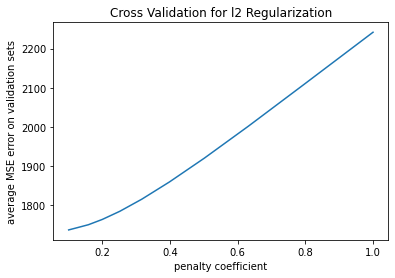

The best penalty coefficient is 0.1
Time:  5.1027165320000005


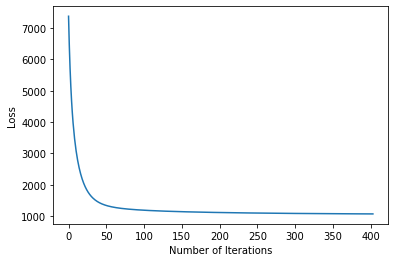

model trained using MSE loss
y-intercept  51.47488784790039
Coefficients  [[ -2.1861956   -2.5950887   -1.5663773   -3.015016    -8.297896
    5.618289     8.018511    -2.7744572    9.079941    -3.0927205
    3.2104573    7.922549     1.9771757    4.5004983   15.711249
   -4.352428    24.424704    -4.605917    -7.37637     14.678244
    3.9951642   23.594099   -13.950023    -2.652978   -13.879165
   -1.5944519   -4.4412675   -0.04084311   0.8920499   -1.3953929
    4.2267203   -1.0097592   -3.1216466   -3.5648422 ]]
Train MSE = 1073.9178646890707
Train R^2 = 0.7584786126324099
Train SPO Loss = [7919.92375227]


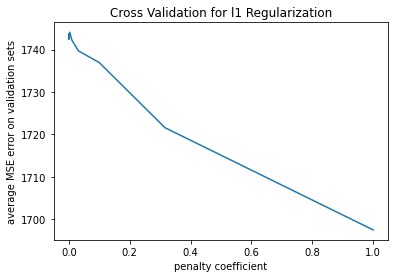

The best penalty coefficient is 1.0
Time:  6.236736860000001


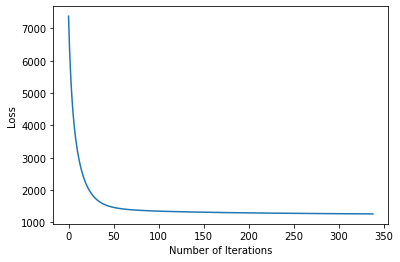

model trained using MSE loss
y-intercept  54.04862594604492
Coefficients  [[-9.8294103e-01 -9.5176214e-01 -3.8470048e-01 -3.8230810e-01
  -4.9152656e+00  2.9993825e+00  5.5551677e+00 -1.0051794e+00
   7.7013512e+00 -2.5987010e+00  2.8827438e-02  5.9711585e+00
   3.0698892e-01  3.3744140e+00  1.8047821e+01 -1.6184752e+00
   2.6848307e+01 -1.2247890e+00 -4.8279061e+00  1.5625892e+01
   4.8353691e+00  2.6437586e+01 -1.2516764e+01 -2.7708986e+00
  -1.3872166e+01 -9.6047789e-01 -2.8439639e+00 -2.8231777e-03
   1.0834042e+00 -5.0622159e-01  4.3222594e+00 -2.0683253e-02
  -2.4988465e+00 -2.7875850e+00]]
Train MSE = 1080.265106989404
Train R^2 = 0.7570511340358241
Train SPO Loss = [8442.99851462]


In [15]:
# ols model training

learningRate = 0.02
epochs = 501

model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None')

# ridge regression (l2 regrularization)

best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2')
model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2)

# l1 regularization (lasso) - penalty coefficient set to be 0.1

best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1')
model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1)

### MSE loss model evaluation

In [16]:
# compile results for models trained on MSE loss
MSE_result = []

for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    MSE_result.append(pd.concat({name:score_df}))
    
MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])
MSE_scores

MSE       R^2     SPO Loss  SPO_MSE_Weighted_Loss  \
mse_ols   train  1014.142704  0.771922  8477.358711            8578.772981   
          test   2097.558765  0.677425  2075.441322            2285.197198   
mse_ridge train  1073.917865  0.758479  7919.923752            8027.315539   
          test   2188.705411  0.663408  1918.388748            2137.259289   
mse_lasso train  1080.265107  0.757051  8442.998515            8551.025025   
          test   2006.497187  0.691429  1800.741057            2001.390776   

                 SPO_MSE_Weighted_Loss Ave  SPO Loss Ave  
mse_ols   train                  37.959172     37.510437  
          test                   36.272971     32.943513  
mse_ridge train                  35.519095     35.043910  
          test                   33.924751     30.450615  
mse_lasso train                  37.836394     37.358401  
          test                   31.768108     28.583191

## SPO loss models

### SPO loss model training

/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


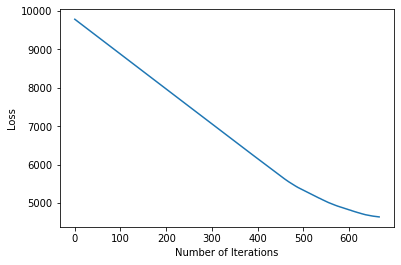

model trained using SPO loss
y-intercept  30.175928115844727
Coefficients  [[-0.40341678 -0.77237767 -0.57134634  0.14639232 -0.730215    0.1521075
   0.72103655  0.6634722   1.9438661  -0.08882263 -0.10136414  1.5625701
   1.6531253   2.4119883   4.6071105  -3.4786263  19.721687    1.0531187
  -2.6163118  19.84787     7.1717544  13.586455   -4.2268057  -1.9318618
  -3.3329594   0.45156866 -0.6021283  -0.12345193  0.45494732  1.332874
   1.2670949   0.6735092  -1.6430583  -0.17522159]]
Train MSE = 2504.206372898962
Train R^2 = 0.4368103769160875
Train SPO Loss = [4640.15060511]


/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


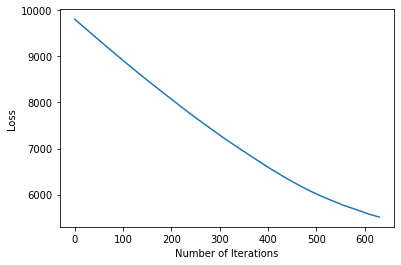

model trained using SPO loss
y-intercept  24.437707901000977
Coefficients  [[-6.7564607e-01 -5.2572119e-01  2.2248311e-01 -3.0279920e-01
  -1.1773851e+00 -5.7197738e-01 -2.0352700e-01 -2.0352270e-02
   1.2755430e+00  7.6460779e-01  5.8086967e-01 -1.0328317e+00
   5.2066612e-01  2.2479141e+00  7.3355203e+00 -4.1000557e+00
   1.0181314e+01 -1.0984200e+00 -3.3772268e+00  8.9395456e+00
   5.1528301e+00  4.7892570e+00 -3.9981439e+00 -2.5141084e+00
   2.1695836e+00  7.5807071e-01  2.4996869e-01 -2.2781033e-16
  -5.2513659e-01  3.2149810e-01  5.0188458e-01 -7.3021072e-01
   2.7669182e-01 -1.0189088e-02]]
Train MSE = 3295.6961341848387
Train R^2 = 0.25880634930979174
Train SPO Loss = [5513.03593295]


/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


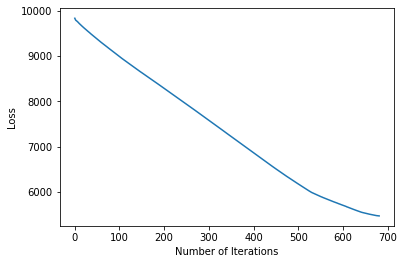

model trained using SPO loss
y-intercept  29.747533798217773
Coefficients  [[-7.3292833e-03 -3.0961124e-02 -8.2921330e-04 -1.1108810e-02
  -2.9723113e-03  7.8586429e-02 -6.5389713e-03  1.5722131e-02
   3.5329703e-02  2.7440572e-03 -4.0098024e-03  1.4327442e-03
   9.5611997e-03  4.7766352e-01  6.6132650e+00 -2.1880672e+00
   1.7079285e+01  3.1792030e-02 -2.6983001e+00  1.8136156e+01
   8.0504684e+00  8.7521534e+00 -3.4196475e+00 -2.1344490e+00
   1.8254705e-02  2.3268061e-02 -1.2817606e-01  3.0558929e-03
  -2.5193837e-02  5.7551086e-01  3.7169105e-01  3.3393558e-02
  -2.4241982e-02 -4.7053061e-02]]
Train MSE = 2689.1762385709476
Train R^2 = 0.39521112612866427
Train SPO Loss = [4754.05195409]


In [17]:
# ols

learningRate = 0.05
epochs = 3001

# model training
model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None')

# ridge regression (l2 regrularization)

#best_l2_spo = cross_validate(x_train, y_train, 'SPO', 'l2')
model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = 2.3357)

# l1 regularization (lasso)

#best_l1_spo = cross_validate(x_train, y_train, 'SPO', 'l1')
model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = 10)

### SPO loss model evaluation

In [18]:
# compile results for models trained on SPO loss
SPO_result = []

for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
    score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
    SPO_result.append(pd.concat({name:score_df}))
    
SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])
SPO_scores.iloc[:,[0,1,2,5]]

MSE       R^2     SPO Loss  SPO Loss Ave
spo_ols   train  2504.206373  0.436810  4640.150605     20.531640
          test   4924.966558  0.242609  2394.023542     38.000374
spo_ridge train  3295.696134  0.258806  5513.035933     24.393964
          test   6194.079878  0.047438  2672.964054     42.428001
spo_lasso train  2689.176239  0.395211  4754.051954     21.035628
          test   5056.194432  0.222428  2405.041444     38.175261

In [19]:
MSE_scores.iloc[:,[0,1,2,5]]

MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train  1014.142704  0.771922  8477.358711     37.510437
          test   2097.558765  0.677425  2075.441322     32.943513
mse_ridge train  1073.917865  0.758479  7919.923752     35.043910
          test   2188.705411  0.663408  1918.388748     30.450615
mse_lasso train  1080.265107  0.757051  8442.998515     37.358401
          test   2006.497187  0.691429  1800.741057     28.583191

# References

In [20]:
%%script false --no-raise-error
import time
# Batch Gradient Descent Using Numpy - For comparison purpose

"""
code is based on Yuhan Cheng's code, approved use
"""

def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    alpha = 0.0
    beta = np.zeros((xvalue_matrix.shape[1],))
    epsilon = 0.00001
    n = float(len(xvalue_matrix))
    loss = []
    for i in range(MaxIterations):
        # compute new coefficients
        y_pred = alpha + np.matmul(xvalue_matrix, beta)
        loss.append(mean_squared_error(y_pred,yvalues))
#         if i % 100 == 0:
#             print('Current Loss:', loss)
        d_alpha = np.mean(y_pred - yvalues)
        d_beta = np.mean((y_pred - yvalues) * xvalue_matrix.T, axis = 1)
        alpha_1 = alpha - (R * d_alpha)
        beta_1 = beta - (R * d_beta)
        
        if np.isnan(alpha_1):
            print('nan at iter', str(i))
            break
        
        # check to see whether stopping criteria has been met
        if (np.abs(alpha_1-alpha)<epsilon) and np.all(np.abs(beta_1-beta)<epsilon):
            alpha, beta = alpha_1, beta_1
            print('error < epsilon, criteria met')
            break
        alpha, beta = alpha_1, beta_1
            
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    print('MSE:', str(loss[-1]))
    print('R2:', str(r2_score(y_true=yvalues, y_pred = y_pred)))
    
    plt.plot(range(len(loss)),loss)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()
    return alpha, beta

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
